### Position velocity diagram

### http://swcarpentry.github.io/training-course/2014/02/motivation-using-aplpy-to-create-publication-quality-astronomical-images/

### https://aplpy.readthedocs.io/en/stable/api/aplpy.FITSFigure.html#aplpy.FITSFigure.set_xaxis_coord_type

### https://aplpy.readthedocs.io/en/stable/

### Import packages

In [85]:
#import matplotlib
#matplotlib.use('TkAgg')
#matplotlib.use('Qt4Agg')
#matplotlib.use('WebAgg')
import matplotlib.pyplot as plt
from astropy.io import fits 
import numpy as np  
import aplpy 
from spectral_cube import SpectralCube 
from matplotlib import lines
from astropy import wcs
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import SkyCoord
import os
import sys
from pvextractor.gui import PVSlicer 
from pvextractor import extract_pv_slice
from pvextractor.geometry import Path
import matplotlib.ticker as ticker
from matplotlib import rc
rc('text', usetex=False)
#%matplotlib inline

### Previous setup

In [86]:
writechan = False ## CHOOSE WHETHER TO WRITE IMAGE TO A FILE (True), OR DISPLAY DIRECTLY (False). #MOD
source=38 
vc=8.0*u.km/u.s

### Data file

In [87]:
filename='/home/juan/Desktop/Research/Data2.0/Serpens/Serpens_Feather_c18o.fits'

In [88]:
outname='pv_testS'+str(source)+'.eps'

### Map setup

In [89]:
leftpanel = [0.12,0.1,0.38,0.8] # (xo,yo,width,height) #MOD
rightpanel = [0.61,0.1,0.38,0.8]
cube0 = SpectralCube.read(filename)
ch0=18 #MOD
chf=54 #MOD
if ch0 != '' and chf !='': 
    cube=cube0.spectral_slab(5 * u.km / u.s, 11 * u.km / u.s) 
    #cube = cube0.subcube(zlo=ch0,zhi=chf)
else:
    cube=cube0
    ch0 = 0
    chf = cube.header['NAXIS3']

In [90]:
cube.shape

(37, 3000, 3000)

### Create figure

In [91]:
fig3 = plt.figure(figsize=(9,6)) #MOD
fig3.clf() 

<Figure size 648x432 with 0 Axes>

### Source coordinates

In [92]:
filenametxt='/home/juan/Desktop/Research/Data/sourcecoordinates.txt'
ra,dec = np.loadtxt(filenametxt,unpack=True,usecols=(0,1),dtype='S')

In [93]:
Ra=[]
Dec=[]
for i in range(len(ra)):
    Ra.append(ra[i].decode("utf-8"))
for i in range(len(dec)):
    Dec.append(dec[i].decode("utf-8"))

In [94]:
coord=SkyCoord(Ra,Dec,frame='icrs',unit=(u.hourangle,u.deg)) 
c = SkyCoord(coord[source-1].ra,coord[source-1].dec, frame='icrs',unit=(u.hourangle,u.deg))

### Source PV Info

### We extract the cut info from 2D fitting performed in CASA. That step has to be done again for the new data.

In [95]:
file2dfit='/home/juan/Desktop/Research/Data2.0/2DFit/'+str(source)+'/2DGssfit'+str(source)+'Log.txt'
file1=open(file2dfit,'r')
i=1
for line in file1:
	if i==27:
		line1=line
	if i==29:
		line2=line
	i+=1
file1.close()
for j in range(len(line1)):
	if line1[j]==':':
		k=j+1
		majax1=''
		while line1[k]!='+':
			majax1+=line1[k]
			k+=1
for j in range(len(line2)):
	if line2[j]==':':
		k=j+1
		angle1=''
		while line2[k]!='+':
			angle1+=line2[k]
			k+=1
dchan=1 #0.5 to shorten interval
amp=5
angle=float(angle1.strip())
majorax=amp*float(majax1.strip())

### PV cut

In [96]:
halflength = majorax/2.*u.arcsec  #MOD
pa = angle*u.deg #Deg: degrees away from vertical.
avnumb=6 #number of pixels to average perpendicular to pv-cut #MOD
inter = 1*u.arcsec #interval you want the arcsec to be marked on #MOD

In [97]:
majorax*u.arcsec

<Quantity 25.045 arcsec>

### Optional

In [98]:
def standard_setup(sp): 
    #sp.set_theme('publication')
    #sp.frame.set_color('black')
    #sp.ticks.show_x()
    #sp.ticks.show_y()
    #sp.tick_labels.set_xformat('hh:mm:ss')
    #sp.tick_labels.set_yformat('dd:mm:ss')
    #sp.tick_labels.show_x()
    #sp.tick_labels.show_y()
    #sp.ticks.set_font(size='14')
    #sp.tick_labels.set_font(size='16')
    sp.set_tick_labels_font(size='14')
    sp.set_axis_labels_font(size='16')
    sp.set_tick_labels_format(xformat='hh:mm:ss',yformat='dd:mm:ss') 
    sp.set_tick_color('black')
    sp.set_system_latex(False) #use latex math symbols in plots
def pv_setup(sp):
    #sp.frame.set_color('black')
    #sp.ticks.show_x()
    #sp.ticks.show_y()
    #sp.tick_labels.set_xformat('mm:ss')
    #sp.tick_labels.set_yformat('dd:mm:ss')
    #sp.tick_labels.show_x()
    #sp.tick_labels.show_y()
    #sp.ticks.set_font(size='14')
    #sp.tick_labels.set_font(size='16')
    sp.set_frame_color('black')
    sp.set_tick_labels_font(size='14')
    sp.set_axis_labels_font(size='16')
    #sp.set_tick_labels_format(xformat='mm:ss',yformat='dd:mm:ss') 
    sp.set_tick_color('black')
    sp.set_system_latex(False)

### Locate source

In [99]:
RAcoord=c.ra
Deccoord=c.dec
xcoord=[0,cube.shape[2]] 
ycoord=[0,cube.shape[1]]
x_w,y_w=[RAcoord.value],[Deccoord.value]
dchan=1 #0.5 to shorten interval
amp=5
upperx = RAcoord+halflength.to(u.deg)*np.sin(pa.to(u.rad))
lowerx = RAcoord-halflength.to(u.deg)*np.sin(pa.to(u.rad))
uppery = Deccoord+halflength.to(u.deg)*np.cos(pa.to(u.rad))
lowery = Deccoord-halflength.to(u.deg)*np.cos(pa.to(u.rad))
endpoints_deg = np.array([[upperx.value,uppery.value],[lowerx.value,lowery.value]]) 

### Make a PV cube

In [100]:
pvcube = cube0.subcube(xlo=xcoord[0],xhi=xcoord[1],ylo=ycoord[0],yhi=ycoord[1],zlo=ch0,zhi=chf+1) #modified from cube to cube0
hdu = pvcube
w = wcs.WCS(hdu.header)

In [101]:
endpoints_pix = w.sub([wcs.WCSSUB_CELESTIAL]).wcs_world2pix([[x,y] for x,y in endpoints_deg], 0) 
endpoints_list=endpoints_pix.tolist() 

In [102]:
path=Path(endpoints_list,width=avnumb) 
pv = extract_pv_slice(hdu,path,wcs=w) 
pv_vel=pvcube.spectral_axis 

In [103]:
minvel = pv_vel.min().value
maxvel = pv_vel.max().value
pvstd = pv.data[0:3,0:20].std() #choose a low signal region #MOD
pvstd2 = pv.data[15:18,170:190].std() #MOD
pvrms = np.nanmean([pvstd,pvstd2])

### Panel (b): PV Plot

In [104]:
F4 = aplpy.FITSFigure(pv,dimensions=[1,0],figure=fig3,subplot=(rightpanel)) 
pv_setup(F4)
#F4.show_grayscale(aspect='auto',pmin=.5,pmax=99.75,stretch='linear',invert=True)
F4.show_contour(colors='orange',levels=[8*pvrms,9*pvrms,12*pvrms],dimensions=[1,0])
#F4.show_contour(colors='orange',levels=10,dimensions=[1,0])

### Modify axes

In [105]:
#F4.refresh() 
#F4.set_system_latex(True)
print([x.get_text()[1:-1] for x in F4._ax1.get_yticklabels()]) 
xlim=F4._ax1.get_xlim() 
ylim=F4._ax1.get_ylim()
xlim_lo = minvel 
xlim_hi = maxvel
ylim_lo=(ylim[0])*pv.header['CDELT1']+pv.header['CRVAL1']-pv.header['CDELT1']
ylim_hi=(ylim[1])*pv.header['CDELT1']+pv.header['CRVAL1']-pv.header['CDELT1']
npix = round(halflength.to(u.deg) / (cube.header['cdelt2']*u.deg))
inter_px = inter.to(u.deg).value/(ylim_hi-ylim_lo)*(ylim[1]-ylim[0])
ntick = (int(int((ylim_hi-ylim_lo)/inter.to(u.deg).value))+2) 
print([x.get_text() for x in F4._ax1.get_yticklabels()])
#F4.refresh() 
F4._ax1.yaxis.set_major_locator(ticker.MultipleLocator(2*inter_px)) 
F4._ax1.yaxis.set_minor_locator(ticker.MultipleLocator(inter_px/inter.value)) 
newticks = np.arange(0,round(inter.value)*round(ntick),2*round(inter.value))-round(halflength.value) 
#newticks=np.array([10,8,6,4,2,0,-2,-4,-6,-8,-10])
F4._ax1.set_yticklabels(newticks)
#F4.refresh()
print([x.get_text()[:-2] for x in F4._ax1.get_yticklabels()])
F4._ax1.set_xticklabels([str(float(x.get_text()[:])/1000.*dchan)[:-2] for x in F4._ax1.get_xticklabels()])
#F4._ax1.set_yticklabels([x.get_text()[:-2] for x in F4._ax1.get_yticklabels()],size=10)##NOTE## Here edit the indexing of x.get_text()[:-2]. #with [:-2] we achieve to do '12.0 -> '12'
F4._ax1.set_ylabel('Offset (arcsec)',size=13) 
F4._ax1.set_xlabel("$V_{LSR} (\mathrm{km\ s}^{-1})$")
print([x.get_text() for x in F4._ax1.get_yticklabels()])
#F4.refresh()
F4._ax2.yaxis.set_major_locator(ticker.MultipleLocator(round(inter_px))) 
F4._ax2.yaxis.set_minor_locator(ticker.MultipleLocator(round(inter_px/inter.value)))
F4._ax1.yaxis.labelpad = -9 
#F4.set_system_latex(False)

[u'', u'.00', u'.00', u'.00', u'.00', u'.00', u'.00']
[u'0', u'0.001', u'0.002', u'0.003', u'0.004', u'0.005', u'0.006']
['-13', '-11', '-9', '-7', '-5', '-3', '-1', '1', '3', '5', '7', '9', '11', '13']
['-13.0', '-11.0', '-9.0', '-7.0', '-5.0', '-3.0', '-1.0', '1.0', '3.0', '5.0', '7.0', '9.0', '11.0', '13.0']


In [106]:
2*inter_px

19.9999999999984

In [107]:
newticks

array([-13., -11.,  -9.,  -7.,  -5.,  -3.,  -1.,   1.,   3.,   5.,   7.,
         9.,  11.,  13.])

### Plot kinematic model lines

### Keplerian rotation: try with different values of M obtained from 2D-Fit performed in CASA

In [108]:
velvalues=np.arange(5,11,0.1)*1000*(u.m/u.s)-vc.to(u.m/u.s)
velvalues2=np.arange(8,11,0.1)*1000*(u.m/u.s)-vc.to(u.m/u.s)
velvalues3=np.arange(5,8,0.1)*1000*(u.m/u.s)-vc.to(u.m/u.s)

In [109]:
#velvalues=np.arange(4,6,0.1)*1000-vc.to(u.m/u.s).value
G=6.674e-11*u.m**3*u.s/u.kg
#Mlist= [8.3*u.Msun,10.1*u.Msun]
Mlist= [0.05*u.Msun,0.15*u.Msun]
colors=['cyan','red']
#In the future make a txt file with the possible masses organized in columns and automate this step to get info of M from there.
l=0
for M in Mlist:
    rvalues=G*M.to(u.kg)*velvalues**-2 ##?## we use gas mass, but what happens to dust mass?
    rvalues2=G*M.to(u.kg)*velvalues2**-2
    rvalues3=G*M.to(u.kg)*velvalues3**-2#(from http://icc.dur.ac.uk/~tt/Lectures/Galaxies/TeX/lec/node41.html)
    rvalarcs=rvalues.value*206265/(436*3.086*10**16)*u.arcsec#from km to arcsec (using smaal angle aprox). Distance to serpens south 436 parsecs
    rvalarcs2=rvalues2.value*206265/(436*3.086*10**16)*u.arcsec
    rvalarcs3=rvalues3.value*206265/(436*3.086*10**16)*u.arcsec
    F4.show_lines([np.array([velvalues2.value+vc.to(u.m/u.s).value,rvalarcs2.to(u.deg).value+halflength.to(u.deg).value])],color=colors[l],linewidths=2.0,linestyles='-')#since we also have negative radii we als have to add
    F4.show_lines([np.array([velvalues3.value+vc.to(u.m/u.s).value,-rvalarcs3.to(u.deg).value+halflength.to(u.deg).value])],color=colors[l],linewidths=2.0,linestyles='-')
    l+=1

### INFALL: (try with the different values of M obtained from the 2d-fit performed in CASA)

### Panel (a): Moment 0 map

### First make moment map

In [110]:
moment_0 = cube0.moment(order=0)

### Plot it next to PV plot

In [111]:
f2 = aplpy.FITSFigure(moment_0.hdu,dimensions=[0,1],figure=fig3,subplot=(leftpanel))
#f2.set_system_latex(False)
standard_setup(f2) 

In [112]:
f2._ax1.yaxis.labelpad = -20 ## Move label closer to figure #MOD

In [113]:
mom0_vmin = np.nanmin(moment_0).value*0.4 #modify multiplicative factor to make #MOD better contrast
mom0_vmax = np.nanmax(moment_0).value*0.6 #Shorten colorscale to make it more sensible for a higher number of pixels. #MOD

In [114]:
f2.show_grayscale(vmin=mom0_vmin,vmax=mom0_vmax,invert=True)

In [115]:
print(mom0_vmin,mom0_vmax)

(-61.5243382036686, 863.3586053319275)


In [116]:
xx=np.abs(cube0.header['NAXIS1']*cube0.header['cdelt1'])
yy=np.abs(cube0.header['NAXIS2']*cube0.header['cdelt2'])

In [117]:
mapwidth=5.*u.arcsec #MOD
mapheight=5.*u.arcsec #MOD

In [118]:
f2.recenter(RAcoord,Deccoord,width=2*mapwidth.to(u.deg).value,height=2*mapheight.to(u.deg).value)
f2.show_markers(RAcoord, Deccoord,marker="*",c='None',edgecolors="magenta",s=300,linewidths=2.0,zorder='9')

### Show PV Cut

In [119]:
f2.show_lines([endpoints_deg.T],color='DarkMagenta',linewidths=2.0,linestyle='-')
#BEAMSIZE
bmaj=1.043*u.arcsec.to(u.deg) #MOD
bmin=0.7046*u.arcsec.to(u.deg) #MOD
bpa=76.299 #MOD
f2.show_beam(major=bmaj,minor=bmin,angle=bpa,fill=True,color='DeepSkyBlue') #MOD
f2.add_label(0.22, 0.9, '(a) C18O map', relative=True, color="Black", size=15) 

### Final annotations

### Horizontal line to show resolution in PV Plot

In [120]:
res_elem = 0.15*u.arcsec ##?## Where do I get this?? #resolution element, or beam size #MOD
x1_res=res_elem.to(u.deg).value 
x2_res=x1_res+res_elem.to(u.deg).value 
y1_res=pvcube.spectral_axis.min().value
y2_res=pvcube.spectral_axis.max().value 

### Beamsize

In [121]:
F4.show_arrows(30080.,3./3600.,0.0,0.5*res_elem.to(u.deg).value,color='DeepSkyBlue',linestyles='-',head_length=0.1,head_width=5) 
F4.show_arrows(30080.,3./3600.,0.0,-0.5*res_elem.to(u.deg).value,color='DeepSkyBlue',linestyles='-',head_length=0.1,head_width=5)
#F4.add_label(23000.,3./3600.,'0.14$^{\prime\prime}$ \n 60 AU',layer='label',color='DeepSkyBlue',size=16, verticalalignment='center')

### Set up a second Axis on top of pv plot, to show annotations (if necessary)

In [122]:
ax2 = fig3.add_axes(rightpanel) 
ax2.set_xlim(xlim_lo,xlim_hi)
ax2.set_ylim(ylim_lo,ylim_hi) 
ax2.set_axis_off()

### VERTICAL (dashed) LINE TO SHOW v_c in PV Plot

In [123]:
hx1 = 0.
hx2 = 2.*halflength.to(u.deg).value
hy1 = vc.to(u.m/u.s).value
ax2.vlines(hy1,hx1,hx2,colors='green',linestyles='dashed',label='$v_c$',zorder='3',lw=2) ##?## ##JP## I am getting vertical line shifted #MOD
#ax2.annotate('$v_c$',xy=(hy1,x1_res*2.0),xycoords='data',color='green',size='16')

### HORIZONTAL (dashed) LINE TO SHOW star position in PV Plot. Separate position to left and right from the source along the position line. 

In [124]:
hx3 = xlim_lo
hx4 = xlim_hi
hy3 = halflength.to(u.deg).value
#### NOTE, You have to move these around a bit depending on your target. #MOD
ax2.hlines(hy3,hx3,hx4,colors='magenta',linestyles='dashed',label='protostar',lw=2)
#ax2.annotate('protostar',xy=(xlim_hi,hy3-2*res_elem.to(u.deg).value),xycoords='data',color='magenta',size='20',verticalalignment='top')
#ax2.annotate('(b) CO, \n PV diag.',xy=(xlim_hi,hy3+8*res_elem.to(u.deg).value),xycoords='data',color='Black',size='20',verticalalignment='top')
F4.add_label(0.18,0.9,'(b) C18O \n PV diag.',relative=True,color='Black',size=15)
F4.add_label(0.8,0.55,'protostar',relative=True,color='magenta',size=13)
F4.add_label(0.5,0.1,'Vc',relative=True,color='green',size=13)

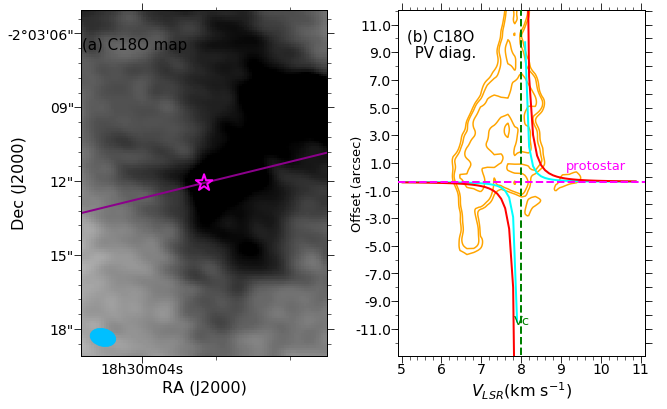

In [125]:
fig3

### Conclusion: Turbulent?

### Show and Save

In [126]:
#if writechan: 
  #plt.savefig(outname)
#if not writechan:
 # print("print to screen")
#fig3.show() 